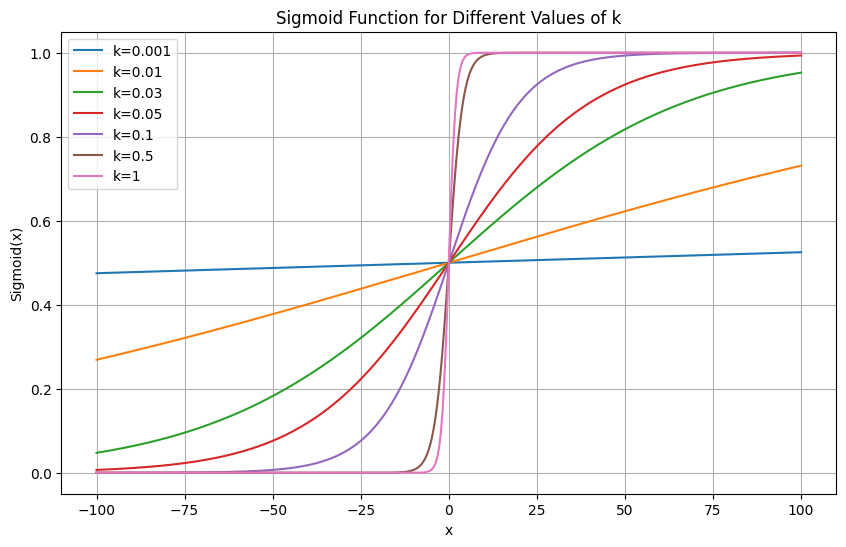

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
import random
from datetime import datetime, timedelta
# Generate sigmoid plots for different values of k
k_values = [0.001,0.01, 0.03,0.05, 0.1, 0.5, 1]
x_values = np.linspace(-100, 100, 400)

def sigmoid(x, L=1, k=0.05, x0=0):
    return L / (1 + np.exp(-k * (x - x0)))

plt.figure(figsize=(10, 6))

for k in k_values:
    y_values = sigmoid(x_values, k=k)
    plt.plot(x_values, y_values, label=f'k={k}')

plt.title('Sigmoid Function for Different Values of k')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)
plt.legend()
plt.show()


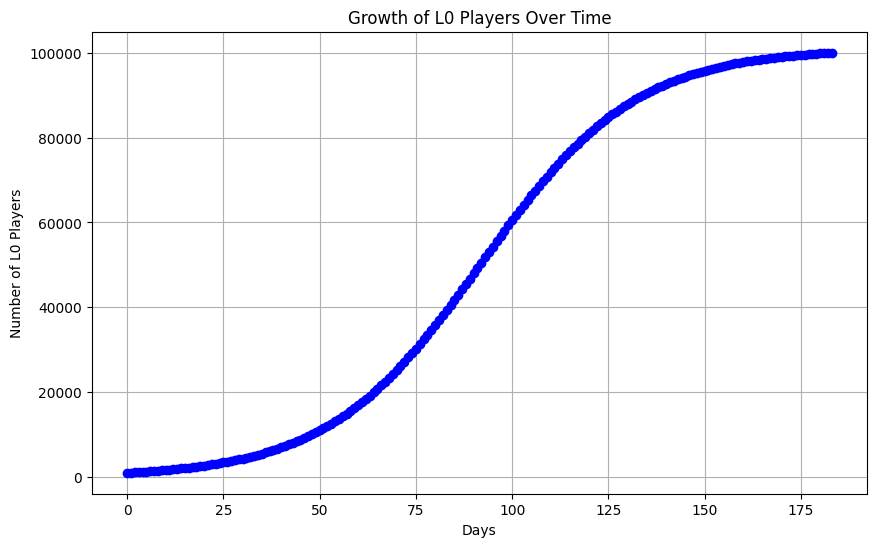

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define constants
INITIAL_USERS = 100000
SIMULATION_START = datetime(2023, 9, 30)
SIMULATION_END = datetime(2024, 3, 31)
DAYS = (SIMULATION_END - SIMULATION_START).days + 1

# Sigmoid function
def sigmoid(x, L=1, k=0.05, x0=0):
    return L / (1 + np.exp(-k * (x - x0)))

# Generate the number of L0 players over the simulation period
x = np.linspace(0, DAYS - 1, DAYS)
L0_growth = sigmoid(x, L=INITIAL_USERS, k=0.05, x0=DAYS / 2)
L0_growth = (L0_growth / np.max(L0_growth) * INITIAL_USERS).astype(int)

# Plot the growth of L0 players
plt.figure(figsize=(10, 6))
plt.plot(range(DAYS), L0_growth, marker='o', linestyle='-', color='b')
plt.title("Growth of L0 Players Over Time")
plt.xlabel("Days")
plt.ylabel("Number of L0 Players")
plt.grid(True)
plt.show()


In [12]:
# latest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
import random
from datetime import datetime, timedelta

# Define constants
INITIAL_USERS = 100  # Initial L0 players at the start (boxes)
NUM_COOKIES = 69
viral_k = 1.1  # shape of pareto distribution for referrals
MAX_USERS = 2000000  # Maximum number of users in the network
COOKIE_TYPES = {
    "Common": 40,
    "Rare": 20,
    "Legendary": 9
}
COOKIE_DISTRIBUTION = {
    "Common": 0.58,
    "Rare": 0.29,
    "Legendary": 0.13
}
INITIAL_BONUS = {
    "Common": 30,  # 30 minutes
    "Rare": 60,    # 60 minutes
    "Legendary": 90  # 90 minutes
}
DECAY_CONSTANT = 0.5  # Bonus is halved each level
COMMISSION_RATE = 0.15  # 15% commission up the chain
MAX_BONUS_HOURS = 504  # 3 weeks, 21 days
MAX_BONUS_MINUTES = MAX_BONUS_HOURS * 60
SIMULATION_START = datetime(2023, 9, 30)
SIMULATION_END = datetime(2024, 3, 31)
DAYS = (SIMULATION_END - SIMULATION_START).days + 1
MAX_REFERRALS_PER_USER = 100000  # Set an arbitrary cap on the maximum number of referrals

# Sigmoid function for growth of L0 players
def sigmoid(x, L=1, k=0.05, x0=0):
    return L / (1 + np.exp(-k * (x - x0)))

# Generate the number of L0 players over the simulation period using a smoother sigmoid curve
x = np.linspace(0, DAYS - 1, DAYS)
L0_growth = sigmoid(x, L=INITIAL_USERS, k=0.05, x0=DAYS / 2) # classic s-curve
L0_growth = (L0_growth / np.max(L0_growth) * INITIAL_USERS).astype(int)

# Initialize users and their cookies using a Pareto distribution
def pareto_distribution(alpha, size, max_value):
    samples = (np.random.pareto(alpha, size) + 1) * max_value / (alpha + 1)
    return np.minimum(samples, max_value).astype(int)

alpha = 2.0  # Shape parameter for the Pareto distribution

# Function to simulate referrals with a power-law distribution
def simulate_referrals( viral_k, new_users, total_users, max_users):
    referrals = defaultdict(list)
    new_users_list = list(new_users)  # Convert set to list to avoid modification during iteration
    for user in new_users_list:
        if total_users >= max_users:  # Check if we have reached the maximum number of users
            break
        
        num_referrals = min(MAX_REFERRALS_PER_USER, max(1, int(np.random.pareto(viral_k) + 1)))

        for _ in range(num_referrals):
            if total_users >= max_users:  # Again, check if we have reached the maximum number of users
                break
            referred_user = total_users
            referrals[user].append(referred_user)
            new_users.add(referred_user)
            total_users += 1
            
    return referrals, total_users

# Calculate time bonuses with exponential decay
def calculate_bonus(cookie_type, level):
    initial_bonus = INITIAL_BONUS[cookie_type]
    decayed_bonus = initial_bonus * (DECAY_CONSTANT ** (level - 1))
    return decayed_bonus

# Propagate commission up the pyramid
def propagate_commission(user, bonus, G):
    current_bonus = bonus
    ancestors = list(nx.ancestors(G, user))
    for ancestor in ancestors:
        commission_bonus = current_bonus * COMMISSION_RATE
        time_bonuses[ancestor] = min(time_bonuses[ancestor] + commission_bonus, MAX_BONUS_MINUTES)
        current_bonus = commission_bonus

# Simulate the referral process over time

G = nx.DiGraph()

time_bonuses = defaultdict(float)
successful_shares = defaultdict(int)
max_levels = defaultdict(int)
user_cookie_counts = defaultdict(lambda: defaultdict(int))

total_users = 0
new_users = set()
users_per_day = []
user_cookies = {}
# Function to assign cookies to new users with a 50/50 chance of keeping the referred cookie or getting a new one
def assign_cookies(user, referring_cookie_type=None):
    if referring_cookie_type and random.random() < 0.5:
        return [referring_cookie_type]
    else:
        cookie_count = pareto_distribution(alpha, 1, NUM_COOKIES)[0]
        return np.random.choice(
            ["Common", "Rare", "Legendary"], 
            size=min(cookie_count, NUM_COOKIES), 
            p=[COOKIE_DISTRIBUTION["Common"], COOKIE_DISTRIBUTION["Rare"], COOKIE_DISTRIBUTION["Legendary"]]
        )

for day in range(DAYS):
    print(f"Day {day + 1}/{DAYS}")
    # Introduce new L0 players for the current day
    num_new_L0_players = L0_growth[day]
    new_L0_players = set(range(total_users, total_users + num_new_L0_players))
    total_users += num_new_L0_players
    new_users.update(new_L0_players)
    
    # Add new L0 players to the graph
    G.add_nodes_from(new_L0_players)
    
    # Generate referrals
    referrals, total_users = simulate_referrals( viral_k, new_users, total_users, MAX_USERS)
    
    # Assign cookies to new users
    for user in range(total_users):
        user_cookies[user] = assign_cookies(user)
    
    # Calculate bonuses and build the graph
    for user, referred_users in referrals.items():
        for i, referred_user in enumerate(referred_users):
            level = i + 1
            for cookie_type in user_cookies[referred_user]:
                bonus = calculate_bonus(cookie_type, level)
                time_bonuses[user] = min(time_bonuses[user] + bonus, MAX_BONUS_MINUTES)
                G.add_edge(user, referred_user)
                propagate_commission(user, bonus, G)
                user_cookie_counts[user][cookie_type] += 1
            successful_shares[user] += 1
            max_levels[user] = max(max_levels[user], level)
    
    # Record the number of users at the end of each day
    users_per_day.append(total_users)

# Count the number of nodes in the network
num_nodes_in_network = len(G.nodes())

# Visualize the referral network
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_size=20, arrowsize=10, with_labels=False)
plt.title("Referral Network")
plt.show()

# Visualize the distribution of time bonuses
time_bonus_values = list(time_bonuses.values())
plt.figure(figsize=(10, 6))
plt.hist(time_bonus_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Time Bonuses")
plt.xlabel("Time Bonus (Minutes)")
plt.ylabel("Frequency")
plt.show()

# Plot the growth in users by day
plt.figure(figsize=(10, 6))
plt.plot(range(DAYS), users_per_day, marker='o', linestyle='-', color='b')
plt.title("Growth in Users by Day")
plt.xlabel("Day")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

# Display summary statistics
summary = pd.DataFrame(time_bonus_values, columns=["Time Bonuses"]).describe()
print(summary)

# Generate a random sample of 100 users and create the performance table
sample_users = random.sample(range(total_users), 100)
performance_data = []

for user in sample_users:
    total_cookies_found = sum(user_cookie_counts[user].values())
    performance_data.append({
        "User ID": user,
        "Time Bonus (Minutes)": time_bonuses[user],
        "Successful Shares": successful_shares[user],
        "Max Propagation Level": max_levels[user],
        "Number of Cookie Types Found": total_cookies_found
    })

performance_df = pd.DataFrame(performance_data)
print(performance_df)


Day 1/184
Day 2/184
Day 3/184


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1059d2d50>>
Traceback (most recent call last):
  File "/Users/possum/Projects/tari/data/.direnv/python-3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Day 4/184


KeyboardInterrupt: 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta

# Define constants
INITIAL_USERS = 100
SIMULATION_START = datetime(2023, 9, 30)
SIMULATION_END = datetime(2024, 3, 31)
DAYS = (SIMULATION_END - SIMULATION_START).days + 1

# Sigmoid function for L0 player growth
def sigmoid(x, L=1, k=0.05, x0=0):
    return L / (1 + np.exp(-k * (x - x0)))

# Generate the number of L0 players over the simulation period
x = np.linspace(0, DAYS - 1, DAYS)
L0_growth = sigmoid(x, L=INITIAL_USERS, k=0.05, x0=DAYS / 2)
L0_growth = (L0_growth / np.max(L0_growth) * INITIAL_USERS).astype(int)

# Initialize data structures to track the growth of L0 and referral users
total_users = 0
new_users = set()
referral_users_per_day = []

# Function to simulate referrals with a power-law distribution
def simulate_referrals(num_users, viral_k, new_users, total_users, max_users):
    referrals = defaultdict(list)
    new_users_list = list(new_users)  # Convert set to list to avoid modification during iteration
    for user in new_users_list:
        num_referrals = max(1, int(np.random.pareto(viral_k) + 1))
        for _ in range(num_referrals):
            referred_user = total_users
            if total_users < max_users:
                referrals[user].append(referred_user)
                new_users.add(referred_user)
                total_users += 1
    return referrals, total_users

viral_k = 1.5  # Increased viral factor
MAX_USERS = 100000000  # Maximum number of users in the network

# Simulate the growth of referral users over the simulation period
for day in range(DAYS):
    # Add new L0 users for the current day
    num_new_L0_players = L0_growth[day]
    new_L0_players = set(range(total_users, total_users + num_new_L0_players))
    total_users += num_new_L0_players
    new_users.update(new_L0_players)
    
    # Simulate referrals for the new users
    referrals, total_users = simulate_referrals(total_users, viral_k, new_users, total_users, MAX_USERS)
    
    # Record the number of referral users at the end of the day
    referral_users_per_day.append(total_users - sum(L0_growth[:day+1]))

# Plot the growth in L0 users and referral users
plt.figure(figsize=(10, 6))
plt.plot(range(DAYS), np.cumsum(L0_growth), marker='o', linestyle='-', color='b', label="L0 Users")
plt.plot(range(DAYS), referral_users_per_day, marker='x', linestyle='-', color='r', label="Referral Users")
plt.title("Growth of L0 Users and Referral Users Over Time")
plt.xlabel("Days")
plt.ylabel("Number of Users")
plt.grid(True)
plt.legend()
plt.show()


KeyboardInterrupt: 

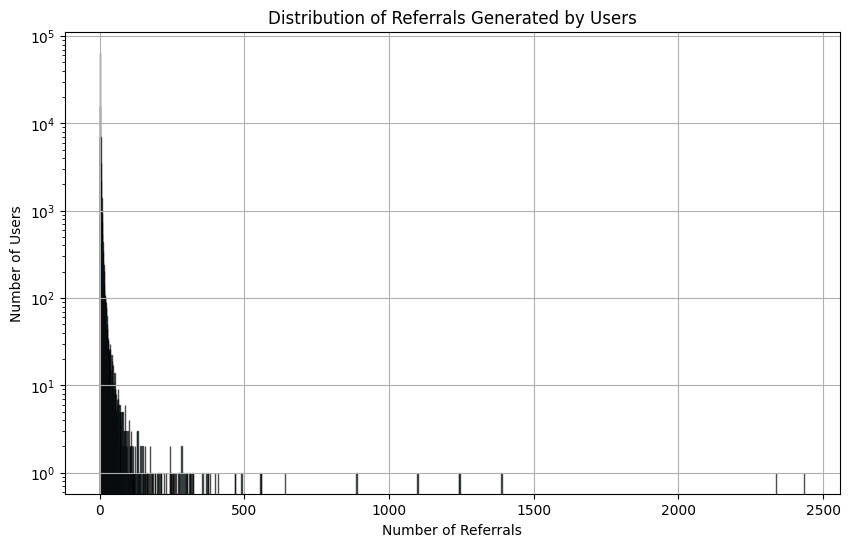

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
viral_k = 1.5  # Viral factor
num_users = 100000  # Number of users to simulate

# Generate the number of referrals for each user using the Pareto distribution
referrals = [max(1, int(np.random.pareto(viral_k) + 1)) for _ in range(num_users)]

# Plot the distribution of referrals
plt.figure(figsize=(10, 6))
plt.hist(referrals, bins=range(1, max(referrals)+1), color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Referrals Generated by Users")
plt.xlabel("Number of Referrals")
plt.ylabel("Number of Users")
plt.grid(True)
plt.yscale('log')  # Use a logarithmic scale to better visualize the tail
plt.show()
